In [16]:
import numpy as np

from scipy.io import wavfile
from scipy.signal import stft


import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten

from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 


from dataset import DatasetGenerator 


import warnings
warnings.filterwarnings('ignore')

In [2]:
dir='E:/Projects/Notebooks/Speech Commands Dataset'
fns=['/off/00b01445_nohash_0.wav',
       '/go/00b01445_nohash_0.wav',
       '/yes/00f0204f_nohash_0.wav']
SAMPLE_RATE = 16000

def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav



Visualization of sinlge words; The following code snippet produces wave plots of  the off, go and yes commands.

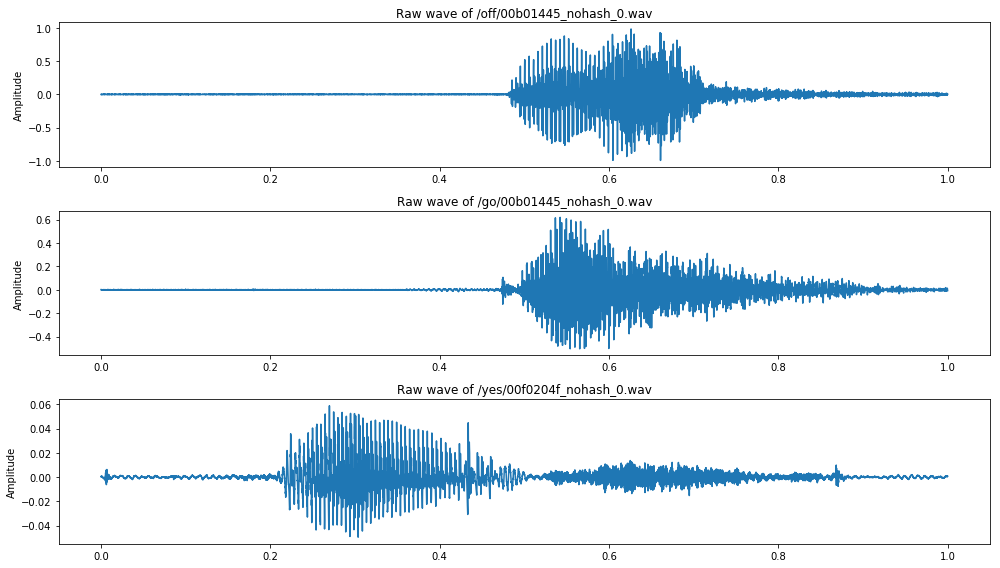

In [3]:
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(dir + fn)
 
    ax = fig.add_subplot(3,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()

One dimensional vectors are easy to visualize, however, in speech recognition we rarely work with a raw amplitude data.
So we are going to use spectograms

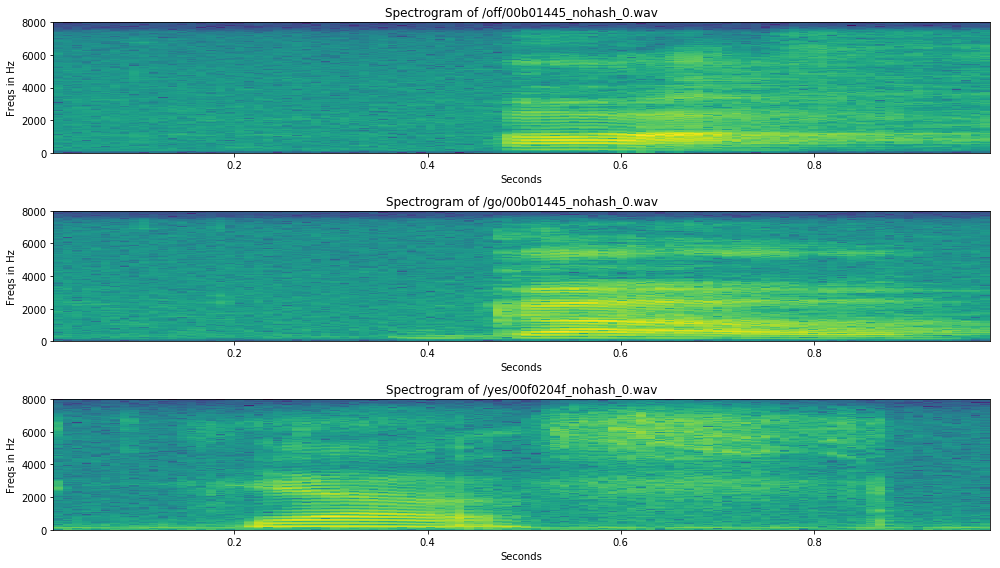

In [4]:
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(dir + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(3,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()

We'll build a machine learning model that'll try to recognize three words yes,  no and up. 


In summary, our plan is to:
    1-Prepare data for selected words including train/test split
    2-Convert raw data to log-spectrograms
    3-Train machine learning model
    4-Check accuracy on test data


In [5]:
#The  INPUT_SHAPE  variable is a size of log-spectrogram. It is 177 x 98 since frequencies above 5500 are removed. 
#We extend it to 3D array so that it can be used in Convolutional Neural Networks.
#BATCH  and  EPOCHS  are used in training of neural networks.
#LABELS  is a list of selected words and  NUM_CLASSES  is just the number of labels that will be predicted. */

INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15
 
LABELS = 'yes no up'.split()
NUM_CLASSES = len(LABELS)



We initialize  DatasetGenerator  class with selected labels. It is better to preprocess the data and create log-spectrograms during training instead of beforehand. It will make the training longer but on the other hand, we would not have to store huge amount of data representing log-spectrograms. 

In [7]:
#fit_generator to preprocess data on the fly. 
#For now, we just map paths to labels with  
dsGen = DatasetGenerator(label_set=LABELS) 
# Load DataFrame with paths/labels 
df = dsGen.load_data(dir)

In [9]:
#The data frame is then split into training and testing parts.
dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)

In [11]:
#approach no.1; fully connected layer architecture

def deep(features_shape, num_classes, act='relu'):
 
    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(512, activation=act, name='dense1')(o)
    o = Dense(512, activation=act, name='dense2')(o)
    o = Dense(512, activation=act, name='dense3')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

In [13]:
#building and compiling the model
model = deep(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
flatten (Flatten)            (None, 17346)             0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               8881664   
_________________________________________________________________
dense2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense3 (Dense)               (None, 512)               262656    
_________________________________________________________________
pred (Dense)                 (None, 3)                 1539      
Total params: 9,408,515
Trainable params: 9,408,515
Non-trainable params: 0
_________________________________________________________________


The Keras  fit_generator  trains the model on data generated by a function defined in generator argument. This allows us to create log-spectrograms for a batch on the fly during training. 
The generator function is a simple procedure that returns processed data for each batch, (for more details look into dataset.py for more details.) Moreover, early stopping has been added in order to stop the training once validation accuracy starts to decrease.

In [15]:
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
 
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

Epoch 1/15
125/125 [==============================] - 32s 258ms/step - loss: 10.8669 - acc: 0.3258 - val_loss: 10.3363 - val_acc: 0.3587
Epoch 2/15
125/125 [==============================] - 32s 256ms/step - loss: 10.8669 - acc: 0.3258 - val_loss: 10.3363 - val_acc: 0.3587
Epoch 3/15
125/125 [==============================] - 32s 255ms/step - loss: 10.8651 - acc: 0.3259 - val_loss: 10.3363 - val_acc: 0.3587
Epoch 4/15
125/125 [==============================] - 33s 262ms/step - loss: 10.8614 - acc: 0.3261 - val_loss: 10.3363 - val_acc: 0.3587
Epoch 5/15
125/125 [==============================] - 32s 257ms/step - loss: 10.8705 - acc: 0.3256 - val_loss: 10.3363 - val_acc: 0.3587
Epoch 00005: early stopping


It turns out that our model does not learn!

In [17]:
##approach no.2; Convolutional Neural Network Architecture


 
def deep_cnn(features_shape, num_classes, act='relu'):
 
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)
 
    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)
 
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
 
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

The generator function outputs 4D array of size (num \textunderscore batches, 177, 98, 1). For each batch CNN accepts 3D array, therefore we need to artificially extend the last dimension of a log-spectrogram (which is already done in ready-to-use dataset.py).

In [19]:
model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
 
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
 
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 177, 98, 32)       320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 49, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 89, 49, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 89, 49, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 25, 32)        0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 45, 25, 32)        128       
__________

To check whether our model generalizes well for unseen samples, we'll calculate the accuracy on the test data.

In [20]:
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
 
y_true = dsGen.df_test['label_id'].values
 
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

67/67 [==============================] - 61s 904ms/step
0.9415614773258532
